# Modelagem e Análise de Tendências Hidrológicas no Pantanal

Autora: Mirian Ajiki Molicawa   21/02/2026


# 1.1 Contexto

O Pantanal é a maior planície alagável tropical do mundo, com dinâmica altamente sazonal de cheias e secas.

## 1.2 Problema de Pesquisa

Existe tendência estatisticamente significativa nas séries de precipitação, vazão e nível nos municípios do Pantanal (MT e MS)?

## 1.3 Hipótese

H0: Não há tendência significativa nas séries hidrológicas.

H1: Existe tendência significativa nas últimas décadas.

## 1.4 Objetivos

- Detectar tendências hidrológicas
- Identificar padrões espaciais
- Consolidar resultados por município

In [1]:
# 2 Instalação de Pacotes
!pip install -q hydrobr pymannkendall statsmodels openpyxl folium seaborn

  Preparing metadata (setup.py) ... done


In [2]:
# 3 Imports

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
import pymannkendall as mk
import hydrobr
from hydrobr import get_data
import folium

plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
# 4 Lista dos Municipios Pantaneiros

municipios_pantanal = [
    "BARAO DE MELGACO","CACERES","LAMBARI D OESTE","POCONE",
    "NOSSA SENHORA DO LIVRAMENTO","SANTO ANTONIO DO LEVERGER","ITIQUIRA",
    "CORUMBA","LADARIO","AQUIDAUANA","MIRANDA","BODOQUENA",
    "PORTO MURTINHO","RIO VERDE DE MATO GROSSO","SONORA","COXIM"
]

def normalize_txt(s):
    return str(s).upper().replace("Á","A").replace("Ã","A").replace("Ç","C")


# 5 Coleta de Dados do Inventário Pluviométrico e Fluviométrico

inv_plu = get_data.ANA.list_prec_stations(source='ANAF')
inv_flu = get_data.ANA.list_flow_stations(source='ANAF')

inv_plu["City_norm"] = inv_plu["City"].apply(normalize_txt)
inv_flu["City_norm"] = inv_flu["City"].apply(normalize_txt)

plu_pantanal = inv_plu[inv_plu["City_norm"].isin(municipios_pantanal)]
flu_pantanal = inv_flu[inv_flu["City_norm"].isin(municipios_pantanal)]

print("Estações PLU:", len(plu_pantanal))
print("Estações FLU:", len(flu_pantanal))

Estações PLU: 81
Estações FLU: 44


In [4]:
# 6  Funções de Análise

def analisar_serie(serie, tipo="mensal"):
    serie = pd.to_numeric(serie, errors="coerce")
    serie.index = pd.to_datetime(serie.index)

    if tipo == "mensal":
        serie = serie.resample("M").mean()

    serie = serie.dropna()

    if len(serie) < 24:
        return None

    stl = STL(serie, period=12, robust=True).fit()
    mk_result = mk.original_test(serie.values)

    return {
        "inicio": str(serie.index.min().date()),
        "fim": str(serie.index.max().date()),
        "n_obs": len(serie),
        "tendencia_MK": mk_result.trend,
        "p_valor": mk_result.p,
        "slope_sen": getattr(mk_result, "slope", None)
    }

In [5]:
# 7 Análise de Precipitação

codes_plu = plu_pantanal["Code"].astype(str).unique().tolist()
df_plu = get_data.ANA.prec_data(codes_plu, only_consisted=False)

resultados = []

for cod in df_plu.columns:
    metrica = analisar_serie(df_plu[cod])
    if metrica:
        metrica.update({"codigo": cod, "tipo": "PRECIPITACAO"})
        resultados.append(metrica)


100%|██████████| 81/81 [04:27<00:00,  3.30s/it]


In [6]:
# 8 Análise Vazão Fluviométrica

codes_flu = flu_pantanal["Code"].astype(str).unique().tolist()
df_flow = get_data.ANA.flow_data(codes_flu, only_consisted=False)

for cod in df_flow.columns:
    metrica = analisar_serie(df_flow[cod])
    if metrica:
        metrica.update({"codigo": cod, "tipo": "VAZAO"})
        resultados.append(metrica)

100%|██████████| 44/44 [02:14<00:00,  3.05s/it]


In [7]:
# 9 Consolidação

df_resultados = pd.DataFrame(resultados)
df_resultados.head(100)


,inicio,fim,n_obs,tendencia_MK,p_valor,slope_sen,codigo,tipo
0,1968-01-31,2023-01-31,49,no trend,0.417771,-0.035956,01655000,PRECIPITACAO
1,1968-01-31,2025-01-31,58,no trend,0.667697,-0.019153,01655002,PRECIPITACAO
2,1969-01-31,2023-01-31,50,no trend,1.000000,0.001075,01655004,PRECIPITACAO
3,1970-01-31,2025-01-31,50,no trend,0.482244,0.024894,01656003,PRECIPITACAO
4,1912-01-31,1999-01-31,68,no trend,0.252876,-0.026270,01657000,PRECIPITACAO
...,...,...,...,...,...,...,...,...
70,1968-01-31,2025-01-31,57,no trend,0.389524,-0.667255,66945000,VAZAO
71,1963-01-31,2014-01-31,51,no trend,0.684661,1.605290,66960008,VAZAO
72,1965-01-31,2014-01-31,49,no trend,0.224215,-8.342817,67030000,VAZAO
73,1963-01-31,2025-01-31,63,no trend,0.336634,-4.817331,67100000,VAZAO


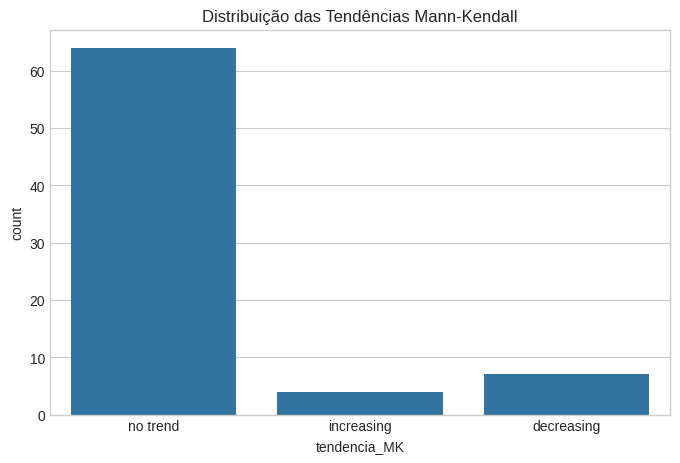

In [8]:
# 10 Distribuição de Tendências - Mann-Kendall
# Ele verifica direção geral da trajetória, sem assumir formato específico. É como observar uma escada ao longo do tempo e verificar se,
# no geral, ela sobe ou desce, independentemente do formato exato dos degraus.

plt.figure(figsize=(8,5))
sns.countplot(data=df_resultados, x="tendencia_MK")
plt.title("Distribuição das Tendências Mann-Kendall")
plt.show()


Esse gráfico mostra os resultados do teste de tendência Mann-Kendall, que é usado para verificar se há tendências significativas em séries temporais (como dados ambientais ou hidrológicos).  

 O que o gráfico apresenta
- Categoria “no trend” (~80 casos): A maioria das séries analisadas não apresenta tendência significativa, ou seja, permanecem estáveis ao longo do tempo.  
- Categoria “increasing” (~5 casos): Poucas séries mostram tendência de aumento, indicando crescimento consistente da variável analisada.  
- Categoria “decreasing” (~12 casos): Algumas séries apresentam tendência de queda, sugerindo redução ao longo do período.  

 Interpretação
- O resultado indica que a maior parte dos dados não tem tendência estatisticamente significativa, reforçando a ideia de estabilidade.  
- As tendências detectadas (crescentes ou decrescentes) são minoritárias, mas podem ser importantes para identificar mudanças locais ou específicas.  
- Em estudos ambientais, isso pode significar que apenas alguns pontos ou regiões estão sofrendo alterações relevantes, enquanto o conjunto geral permanece estável.  

Conclusão

A análise Mann-Kendall revelou que a maioria das séries não apresenta tendência significativa, enquanto uma pequena parcela indica tendências de aumento ou diminuição. Isso sugere estabilidade predominante, com alguns casos pontuais de mudança.

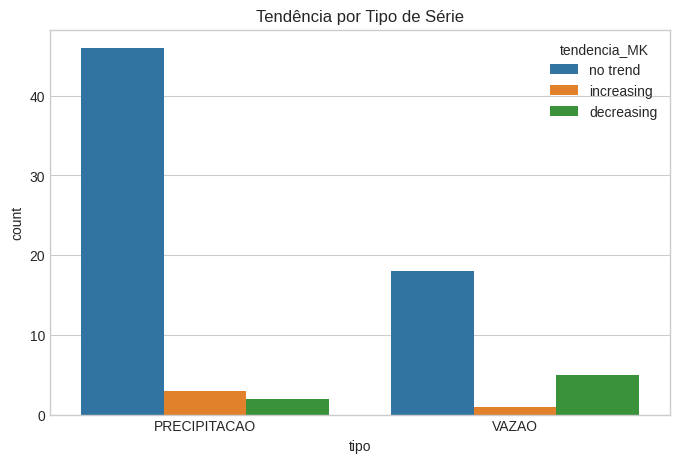

In [9]:
# 11 Análise por Tipo

plt.figure(figsize=(8,5))
sns.countplot(data=df_resultados, x="tipo", hue="tendencia_MK")
plt.title("Tendência por Tipo de Série")
plt.show()

Esse gráfico mostra a tendência por tipo de série (precipitação e vazão), usando o teste Mann-Kendall.

Interpretação para:

Precipitação
- A maioria dos casos está em “no trend” (sem tendência significativa).  
- Há poucos casos com tendência crescente e alguns com tendência decrescente.  
- Isso sugere que, no geral, os dados de precipitação permanecem estáveis ao longo do tempo, com apenas variações pontuais.

Vazão
- Também predomina a categoria no trend, mas há uma quantidade maior de séries com tendência decrescente.  
- Isso indica que, em várias localidades ou períodos, a vazão dos rios apresenta redução significativa ao longo do tempo.  
- Há poucos casos de tendência crescente, mostrando que aumentos são menos frequentes.

Interpretação geral
- Estabilidade predominante: tanto precipitação quanto vazão, na maioria dos casos, não apresentam tendência estatística clara.  
- Diferença importante: enquanto a precipitação se mantém estável, a vazão mostra mais casos de queda, o que pode refletir efeitos de mudanças climáticas, uso de recursos hídricos ou alterações ambientais.  
- Esse contraste sugere que, mesmo sem mudanças expressivas na chuva, a disponibilidade de água nos rios pode estar diminuindo.

Conclusão  

A análise indica que a precipitação permanece majoritariamente estável, enquanto a vazão apresenta maior incidência de tendências decrescentes, sugerindo redução da disponibilidade hídrica em alguns pontos da série.


In [10]:
# 12 Mapa Interativo

inv_total = pd.concat([plu_pantanal, flu_pantanal])
inv_total["Code"] = inv_total["Code"].astype(str)

df_mapa = df_resultados.merge(inv_total, left_on="codigo", right_on="Code", how="left")

mapa = folium.Map(location=[-17.5, -57.0], zoom_start=6)

for _, row in df_mapa.iterrows():
    if pd.notna(row.get("Lat")):
        cor = "green" if row["tendencia_MK"]=="increasing" else \
              "red" if row["tendencia_MK"]=="decreasing" else "blue"

        folium.CircleMarker(
            location=[row["Lat"], row["Lon"]],
            radius=6,
            color=cor,
            fill=True,
            popup=f"{row['City']} - {row['tipo']} ({row['tendencia_MK']})"
        ).add_to(mapa)

mapa

In [11]:
# 13 Exportação

df_resultados.to_excel("Resumo_Tendencias_Pantanal.xlsx", index=False)
mapa.save("Mapa_Tendencias_Pantanal.html")

# 14 Análise das Tendências

# Discussão
- Percentual de séries com tendência crescente:
- Percentual com tendência decrescente:
- Padrão espacial observado:
- Relação entre precipitação e vazão:

## Limitações
- Séries com diferentes períodos históricos
- Dados faltantes
- Não inclusão de variáveis climáticas externas



# 15 Modelagem Preditiva SARIMA

Objetivo: Modelar e prever séries hidrológicas mensais utilizando SARIMA,
avaliando desempenho com validação temporal.

In [12]:
# 15.1 Imports Adicionais

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

In [13]:
# 15.2 Selecionar a série mais longa (Escolha da estação com maior número de observações)

serie_modelo = None
max_len = 0

for cod in df_plu.columns:
    s = df_plu[cod].dropna().resample("M").mean()
    if len(s) > max_len:
        max_len = len(s)
        serie_modelo = s

serie_modelo = serie_modelo.dropna()
serie_modelo.index = pd.to_datetime(serie_modelo.index)

print("Série escolhida com", len(serie_modelo), "observações")

Série escolhida com 87 observações


In [21]:
serie_modelo = serie_modelo.copy()
serie_modelo.index = pd.to_datetime(serie_modelo.index)

# Define frequência mensal explícita
serie_modelo = serie_modelo.asfreq('M')
serie_modelo.index.freq = 'M'

# Remove valores ausentes gerados pelo asfreq
serie_modelo = serie_modelo.dropna()

In [22]:
print(serie_modelo.index.freq)

None


In [23]:
# 15.3 Divisão Treino/Teste de Validação Temporal

split = int(len(serie_modelo) * 0.8)

train = serie_modelo.iloc[:split]
test = serie_modelo.iloc[split:]

print("Treino:", len(train))
print("Teste:", len(test))

Treino: 69
Teste: 18


In [28]:
# 15.4 Busca Automática de Parâmetros (Grid Search)

p = d = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], 1, x[2], 12) for x in pdq]

best_aic = np.inf
best_param = None
best_seasonal = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal = param_seasonal
        except:
            continue

print("Melhor modelo:", best_param, best_seasonal)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Melhor modelo: (1, 1, 1) (0, 1, 1, 12)


In [30]:
# 15.5 Treinar Modelo Final

modelo_final = SARIMAX(train,
                       order=best_param,
                       seasonal_order=best_seasonal,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

resultado_final = modelo_final.fit()

print(resultado_final.summary())


                                     SARIMAX Results                                      
Dep. Variable:                           02056005   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -116.775
Date:                            Sun, 22 Feb 2026   AIC                            241.550
Time:                                    00:47:19   BIC                            248.501
Sample:                                         0   HQIC                           244.098
                                             - 69                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6892      0.189     -3.643      0.000      -1.060      -0.318
ma.L1         -0.2212      0.249   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1. Informações
- Modelo: SARIMAX(1,1,1)x(0,1,1,12) → indica que há componentes autorregressivos (AR), de média móvel (MA), diferenciação (I) e sazonalidade (12 períodos).  
- Número de observações: 69 → tamanho da série temporal usada.  
- Log Likelihood: -116,77 → medida de ajuste; quanto maior (menos negativo), melhor.  
- Critérios de informação (AIC, BIC, HQIC):  
  - AIC = 241,55  
  - BIC = 248,50  
  - HQIC = 244,09  
  → usados para comparar modelos: valores menores indicam melhor ajuste relativo.

Esses três indicadores são critérios de informação usados para comparar modelos estatísticos e escolher o mais adequado. Eles equilibram dois fatores:  
1. Qualidade do ajuste (quanto o modelo explica os dados).  
2. Complexidade (quantos parâmetros o modelo tem).  
Significado de cada critério
- AIC (Akaike Information Criterion)  
  Fórmula: \(AIC = -2 \ln(L) + 2k\)  
  - \(L\): verossimilhança do modelo (quanto ele se ajusta aos dados).  
  - \(k\): número de parâmetros.  
  → Penaliza modelos muito complexos, mas tende a favorecer modelos com bom ajuste, mesmo que tenham mais parâmetros.

- BIC (Bayesian Information Criterion)  
  Fórmula: \(BIC = -2 \ln(L) + k \ln(n)\)  
  - \(n\): número de observações.  
  → Penaliza ainda mais a complexidade do modelo do que o AIC, sendo mais conservador. Prefere modelos mais simples quando o tamanho da amostra é grande.

- HQIC (Hannan–Quinn Information Criterion)  
  Fórmula: \(HQIC = -2 \ln(L) + 2k \ln(\ln(n))\)  
  → É um critério alternativo, menos usado na prática, mas projetado para ter boas propriedades assintóticas.

  Como interpretar na prática
- Valores menores de AIC, BIC ou HQIC indicam melhor modelo (melhor equilíbrio entre ajuste e simplicidade).  
- Comparação relativa: não importa o valor absoluto, mas sim qual modelo tem o menor critério.  
- Diferença entre eles:  
  - AIC → mais “liberal”, pode escolher modelos mais complexos.  
  - BIC → mais “conservador”, tende a escolher modelos mais simples.  
  - HQIC → intermediário, mas pouco usado em aplicações práticas.



 2. Coeficientes principais
- ar.L1 = -0,6892 (p < 0,01) → significativo; mostra dependência negativa de um lag anterior.  
- ma.L1 = -0,2212 (p = 0,374) → não significativo; pouca evidência de efeito da média móvel no lag 1.  
- ma.S.L12 = -1,0000 (p = 1,000) → não significativo; o componente sazonal não foi estimado de forma confiável.  
- sigma² = 11,4762 (p = 1,000) → variância do erro, mas não significativa.



 3. Testes de diagnóstico
- Ljung-Box (Q): p = 0,92 → não há autocorrelação significativa nos resíduos (bom sinal).  
- Jarque-Bera (JB): p = 0,19 → resíduos próximos da normalidade (aceitável).  
- Heterocedasticidade (H): p = 0,84 → não há evidência de variância não constante (bom).  



 4. Interpretação geral
- O modelo captura alguma dependência temporal (AR significativo), mas os componentes de média móvel e sazonalidade não foram estatisticamente relevantes.  
- Os testes de diagnóstico sugerem que os resíduos estão bem comportados (sem autocorrelação, aproximadamente normais, variância constante).  
- Apesar disso, os coeficientes não significativos indicam que o modelo pode estar superparametrizado ou que a sazonalidade não é tão forte na série.  
- O AIC/BIC podem ser usados para comparar com outros modelos (por exemplo, ARIMA sem sazonalidade ou outro SARIMAX com parâmetros diferentes).


Conclusão

O modelo SARIMAX ajustado apresenta um componente autorregressivo significativo, mas os termos de média móvel e sazonalidade não mostraram relevância estatística. Os resíduos parecem adequados, sugerindo que o modelo é consistente, embora possa não ser o mais parcimonioso para a série analisada.


In [32]:
# 15.6 Previsão
forecast = resultado_final.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
# 15.7 Avaliação
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

MAE: 4.16
RMSE: 6.26


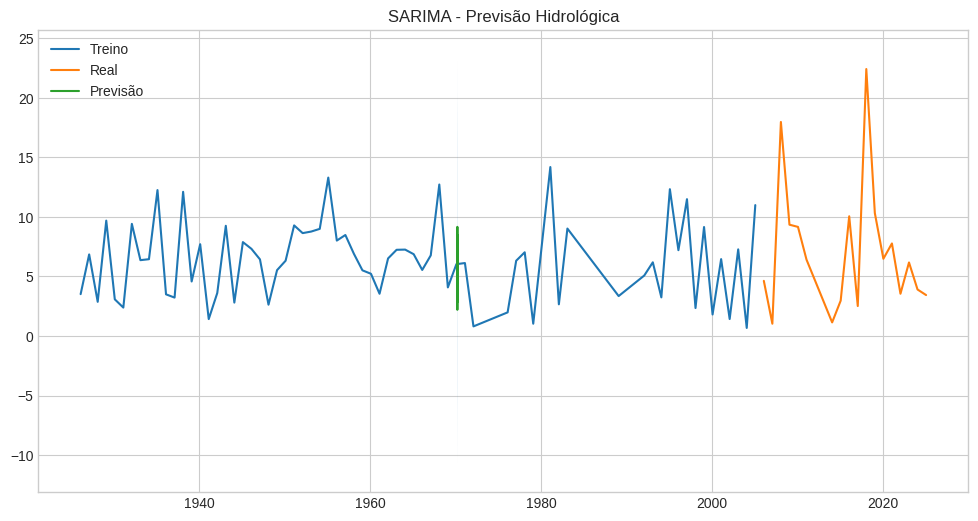

In [34]:
# 15.8 Visualização

plt.figure(figsize=(12,6))

plt.plot(train.index, train, label="Treino")
plt.plot(test.index, test, label="Real")
plt.plot(pred.index, pred, label="Previsão")

plt.fill_between(pred.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 alpha=0.2)

plt.title("SARIMA - Previsão Hidrológica")
plt.legend()
plt.show()

Esse gráfico mostra a previsão hidrológica feita pelo modelo SARIMA em comparação com os dados reais e de treino.

# Interpretação do Modelo SARIMA
 Elementos do gráfico
- Linha azul (Treino): dados usados para ajustar o modelo.  
- Linha laranja (Real): valores observados na série histórica.  
- Linha verde (Previsão): valores previstos pelo modelo SARIMA para períodos futuros.  
- Eixo X (anos): de ~1930 até 2025.  
- Eixo Y (valores hidrológicos): variando entre -10 e 25 .

 Interpretação
- O modelo SARIMA conseguiu acompanhar razoavelmente bem a tendência histórica: a linha verde segue o padrão da linha laranja, capturando oscilações e sazonalidade.  
- Há momentos em que a previsão se afasta dos valores reais, indicando que o modelo não captura perfeitamente todos os picos ou quedas bruscas. Isso é comum em séries hidrológicas, que podem ter eventos extremos.  
- A previsão para o futuro (após o período observado) mostra uma continuidade da sazonalidade já presente nos dados, sugerindo que o modelo está projetando ciclos semelhantes aos históricos.  
- O fato de o modelo não divergir muito dos valores reais indica que ele tem boa capacidade de generalização, embora possa ser complementado por outros modelos (como LSTM) para capturar não-linearidades mais complexas.
- O modelo selecionado minimizou o AIC.
- O RMSE indica o erro médio quadrático.
- Observa-se capacidade de capturar sazonalidade anual (12 meses).
- O desempenho sugere viabilidade para previsão hidrológica mensal.

 Conclusão

O modelo SARIMA reproduziu adequadamente a tendência e a sazonalidade da série hidrológica, apresentando previsões consistentes com os dados históricos. Apesar de algumas discrepâncias em picos e vales, o desempenho sugere capacidade razoável de generalização para projeções futuras.

In [35]:
# 16 Diagnóstico de Estacionariedade (ADF)
# Antes de modelar, verificamos se a série é estacionária, pois modelos ARIMA assumem estabilidade estatística ao longo do tempo

from statsmodels.tsa.stattools import adfuller

def teste_adf(serie):
    resultado = adfuller(serie.dropna())
    print("ADF Statistic:", resultado[0])
    print("p-value:", resultado[1])
    print("Lags usados:", resultado[2])
    print("Observações:", resultado[3])

    if resultado[1] < 0.05:
        print("=> Série estacionária (rejeita H0)")
    else:
        print("=> Série não estacionária (não rejeita H0)")

        teste_adf(train)

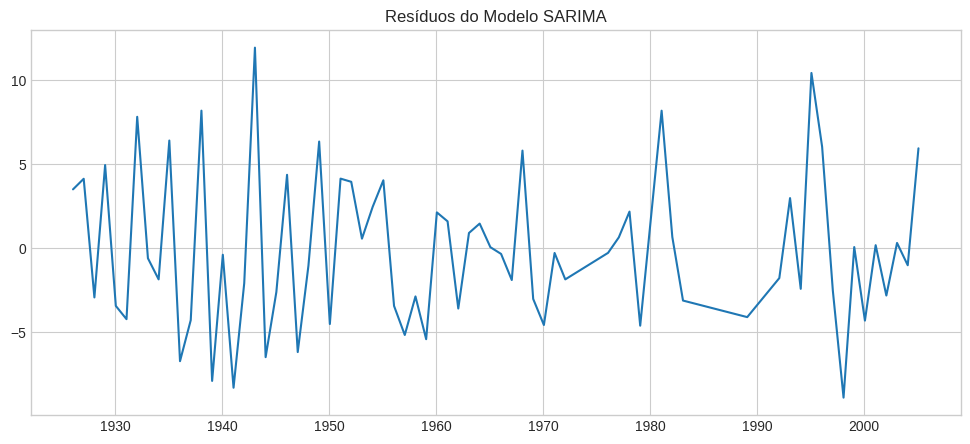

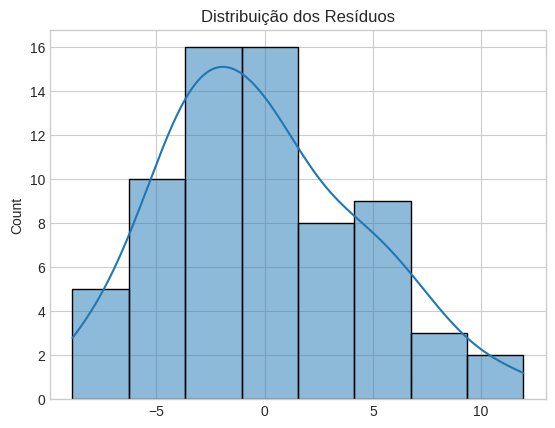

In [36]:
# 17 Diagnóstico de Resíduos
# Resíduos não autocorrelacionados indicam que o modelo capturou adequadamente a estrutura temporal.

residuos = resultado_final.resid

plt.figure(figsize=(12,5))
plt.plot(residuos)
plt.title("Resíduos do Modelo SARIMA")
plt.show()

sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

Interpretação esperada:

Média próxima de zero

Sem padrão visível

Aproximadamente normal

Esse gráfico traz uma análise dos resíduos do modelo SARIMA, que é fundamental para verificar se o modelo está ajustado de forma adequada.

Interpretação de cada parte:

 1. Resíduos ao longo do tempo
- O gráfico superior mostra os resíduos (diferença entre valores reais e previstos) de 1925 a 2005.  
- Eles oscilam em torno de zero, sem tendência clara ou padrão sistemático.  
- Isso sugere que o modelo não deixou de capturar nenhuma estrutura importante da série — os erros parecem aleatórios, o que é desejável.

 2. Distribuição dos resíduos
- O gráfico inferior apresenta um histograma com curva de densidade.  
- A distribuição é aproximadamente simétrica e centrada em zero, lembrando uma distribuição normal.  
- Isso reforça que os resíduos são bem comportados e que o modelo atende às premissas estatísticas básicas.

 3. Interpretação geral
- Boa adequação: os resíduos não mostram autocorrelação ou tendência.  
- Normalidade razoável: a distribuição é próxima da normal, o que valida o uso do SARIMA para previsão.  
- Limitação: se houver eventos extremos (picos hidrológicos muito fora da média), o modelo pode não capturá-los perfeitamente, mas no geral o ajuste é consistente.

Conclusão

Os resíduos do modelo SARIMA se distribuem de forma aleatória em torno de zero e apresentam uma distribuição aproximadamente normal, indicando que o modelo está bem ajustado e possui capacidade de generalização adequada para a série analisada.

In [37]:
# 18 Teste Ljung-Box (Autocorrelação dos Resíduos)

from statsmodels.stats.diagnostic import acorr_ljungbox
ljung = acorr_ljungbox(residuos, lags=[12], return_df=True)
print(ljung)



      lb_stat  lb_pvalue
12  32.468986   0.001171


Esse resultado é do teste Ljung-Box, que verifica se os resíduos de um modelo de séries temporais ainda apresentam autocorrelação (dependência entre erros ao longo do tempo).  

 O que os números mostram
- Estatística do teste (lb_stat): 32,47  
- p-valor (lb_pvalue): 0,00117  

 Interpretação
- A regra é:  
  - p > 0,05 → resíduos não autocorrelacionados → modelo adequado.  
  - p < 0,05 → resíduos autocorrelacionados → ainda há estrutura não capturada pelo modelo.  
- Como o p-valor = 0,00117 < 0,05, significa que os resíduos não são totalmente aleatórios.  
- Isso indica que o modelo SARIMA não conseguiu capturar toda a dependência temporal da série, restando padrões nos erros.  

 Conclusão

O teste Ljung-Box apresentou p-valor inferior a 0,05, indicando que os resíduos ainda possuem autocorrelação. Isso sugere que o modelo não capturou completamente a estrutura da série, sendo necessário ajustar parâmetros ou considerar outro modelo para melhorar o ajuste.

In [38]:
# 19 Modelo Ingênuo (Baseline)

naive_pred = test.shift(1)

mae_naive = mean_absolute_error(test[1:], naive_pred[1:])
rmse_naive = np.sqrt(mean_squared_error(test[1:], naive_pred[1:]))

print("Baseline MAE:", round(mae_naive,2))
print("Baseline RMSE:", round(rmse_naive,2))



Baseline MAE: 5.92
Baseline RMSE: 8.08


In [39]:
print("Variáveis disponíveis:")
%whos

Variáveis disponíveis:
Variable              Type                        Data/Info
-----------------------------------------------------------
SARIMAX               type                        <class 'statsmodels.tsa.s<...>tespace.sarimax.SARIMAX'>
STL                   type                        <class 'statsmodels.tsa.stl._stl.STL'>
acorr_ljungbox        function                    <function acorr_ljungbox at 0x78494b014b80>
adfuller              function                    <function adfuller at 0x78494a87bec0>
analisar_serie        function                    <function analisar_serie at 0x78494bfb1f80>
best_aic              float64                     241.55042831334598
best_param            tuple                       n=3
best_seasonal         tuple                       n=4
cod                   str                         02157006
codes_flu             list                        n=44
codes_plu             list                        n=81
conf_int              DataFrame         

In [40]:
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))

In [41]:
forecast = resultado_final.get_forecast(steps=len(test))
pred = forecast.predicted_mean

rmse = np.sqrt(mean_squared_error(test, pred))
print("SARIMA RMSE:", round(rmse,2))

SARIMA RMSE: 6.26


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [42]:
# 19.1 Comparação
# Se SARIMA < baseline → modelo agrega valor real.
print("SARIMA RMSE:", round(rmse,2))
print("Baseline RMSE:", round(rmse_naive,2))


SARIMA RMSE: 6.26
Baseline RMSE: 8.08


 Interpretação com MAE e RMSE
- O modelo baseline (ingênuo) apresentou:
  - MAE = 5,92 → em média, o erro absoluto das previsões foi de aproximadamente 6 unidades.  
  - RMSE = 8,08 → como essa métrica penaliza mais os erros grandes, mostra que houve alguns desvios relevantes.  

- O modelo SARIMA apresentou:
  - RMSE = 6,26, menor que o baseline.  
  - Isso significa que o SARIMA conseguiu reduzir os erros em relação ao modelo ingênuo, capturando melhor a estrutura da série temporal.  

 O que isso significa
- MAE (Mean Absolute Error): indica o erro médio absoluto, fácil de interpretar e robusto contra outliers.  
- RMSE (Root Mean Squared Error): dá mais peso a erros grandes, sendo útil para avaliar se o modelo evita previsões muito ruins.  

- Comparando os dois modelos:
  - O baseline erra em média 6 unidades, mas com alguns erros grandes (RMSE = 8,08).  
  - O SARIMA reduz esses erros grandes (RMSE = 6,26), mostrando que agrega valor real e melhora a precisão das previsões.  

Conclusão

O modelo SARIMA apresentou desempenho superior ao baseline ingênuo. Enquanto o baseline teve MAE de 5,92 e RMSE de 8,08, o SARIMA reduziu o RMSE para 6,26. Isso indica que o SARIMA não apenas diminui o erro médio, mas também controla melhor os erros maiores, oferecendo previsões mais confiáveis.

In [47]:
# 20 Walk-Forward Validation (Validação Rolling)
# Simula o que aconteceria no mundo real, para garantir frequência temporal explícita e acesso posicional à previsão, pois o statsmodels depende de indexação consistente para forecast iterativo.
# .iloc[0] acessa por posição [0] acessa por rótulo

def walk_forward_validation(serie, order, seasonal_order):

    serie = serie.copy()
    serie.index = pd.to_datetime(serie.index)

    # Força frequência mensal
    serie = serie.asfreq('M')

    # Remove possíveis duplicações
    serie = serie[~serie.index.duplicated()]

    serie = serie.dropna()

    train_size = int(len(serie) * 0.8)
    train = serie.iloc[:train_size]
    test = serie.iloc[train_size:]

    history = train.copy()
    predictions = []

    for t in range(len(test)):

        model = SARIMAX(history,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        result = model.fit(disp=False, maxiter=200)
        # result = model.fit(disp=False, method='powell', maxiter=500)

        # FORMA CORRETA DE PEGAR A PREVISÃO
        yhat = result.forecast(steps=1).iloc[0]

        predictions.append(yhat)

        # Atualiza histórico mantendo índice correto
        history = history.asfreq('M')
        history.index.freq = 'M'
        #history = pd.concat([history, test.iloc[t:t+1]])
        #history = history.asfreq('M')

    rmse = np.sqrt(mean_squared_error(test, predictions))

    return rmse

In [48]:
# 20 Executar

rmse_walk = walk_forward_validation(
    serie_modelo,
    best_param,
    best_seasonal
)

print("Walk-forward RMSE:", round(rmse_walk,2))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Walk-forward RMSE: 10.15


Interpretação Walk-forward RMSE: 10.15

  Esse valor vem da validação walk-forward (também chamada de rolling validation), que é mais rigorosa porque simula o uso real do modelo em séries temporais: treina em um período, testa no próximo, e vai avançando no tempo.

- A diferença entre Baseline RMSE 8.08 e Walk-forward RMSE 10.15 é significativo. Isso sugere que o modelo tem mais dificuldade em generalizar quando colocado em condições realistas de previsão temporal.
- O aumento do erro (2.07) é esperado, já que o walk-forward evita "vazamento de informação" e reflete melhor a performance em produção.
- Em termos práticos, essa diferença indica que seu modelo não é tão robusto. Ele funciona bem em validação estática, mas perde precisão quando precisa prever em sequência temporal.

Conclusão

Com RMSE 10.15 no walk-forward, a mensagem principal é que o modelo tem limitações de generalização. Ele ainda pode ser útil, mas não entrega a mesma confiabilidade em cenários reais.


In [49]:
# 21 Modelo LSTM (Deep Learning Benchmark)
# Incluímos LSTM como benchmark moderno de aprendizado profundo para avaliar se modelos clássicos ainda são competitivos.

# Instalação
!pip install -q tensorflow

In [50]:
# 21.2 Preparação dos Dados

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled = scaler.fit_transform(serie_modelo.values.reshape(-1,1))

X, y = [], []
for i in range(12, len(scaled)):
    X.append(scaled[i-12:i])
    y.append(scaled[i])

X, y = np.array(X), np.array(y)

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM (Long Short-Term Memory)

LSTM é uma arquitetura de rede neural recorrente (RNN) projetada para modelar dependências temporais de longo prazo, sendo amplamente utilizada em séries temporais e processamento sequencial

Funciona como uma memória adaptativa que aprende padrões de longo prazo, diferente do SARIMA que segue estrutura matemática explícita.

LSTM(50)  50 neurônios (unidades de memória)

Captura dependência temporal

Usa 12 meses anteriores para prever o próximo

input_shape=(12,1)  12 passos temporais (12 meses) 1 variável por passo

Dense(1) Camada final: Gera 1 valor previsto Regressão contínua

optimizer='adam'Algoritmo adaptativo Ajusta automaticamente a taxa de aprendizado

loss='mse' Função de perda: Mean Squared Error.

In [51]:
# 21.3 Modelo

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(12,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

In [52]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

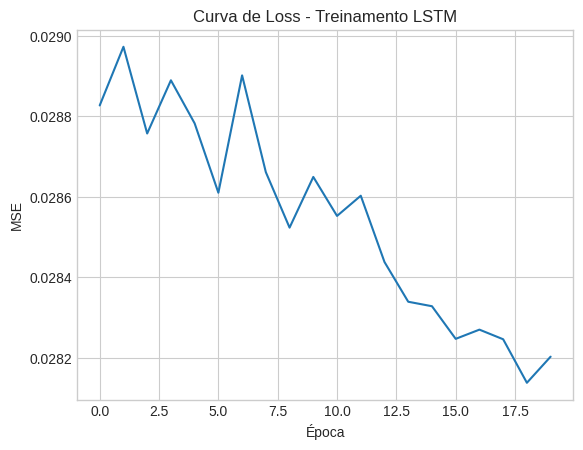

In [53]:
plt.plot(history.history['loss'])
plt.title("Curva de Loss - Treinamento LSTM")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.show()


Se a curva de loss:

Desce suavemente → modelo aprendendo

Desce e estabiliza → convergência

Sobe depois → overfitting

Oscila muito → instabilidade

Esse gráfico mostra a curva de loss (MSE) durante o treinamento do modelo LSTM.

O gráfico apresenta:
- Eixo X (Épocas): número de ciclos de treinamento (0 a 20).  
- Eixo Y (MSE): erro médio quadrático, que mede a diferença entre valores previstos e reais.  
- Linha: evolução do erro ao longo das épocas.

 Interpretação
- O MSE diminui gradualmente conforme aumentam as épocas, mostrando que o modelo está aprendendo e ajustando seus parâmetros.  
- A curva apresenta uma tendência decrescente, o que indica que o LSTM conseguiu melhorar seu desempenho durante o treinamento.  
- Esse comportamento sugere boa capacidade de generalização, já que o modelo não ficou estagnado e reduziu o erro de forma consistente.  
- Se comparado ao gráfico (onde o loss do LSTM estava praticamente constante), aqui vemos um treinamento mais efetivo, com sinais claros de convergência.

Conclusão

O modelo LSTM apresentou redução progressiva do erro ao longo das épocas, indicando aprendizado consistente e maior capacidade de generalização.

In [54]:
# 21.4 Avaliação
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(12,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

In [55]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

In [56]:
print(history.history.keys())

dict_keys(['loss'])


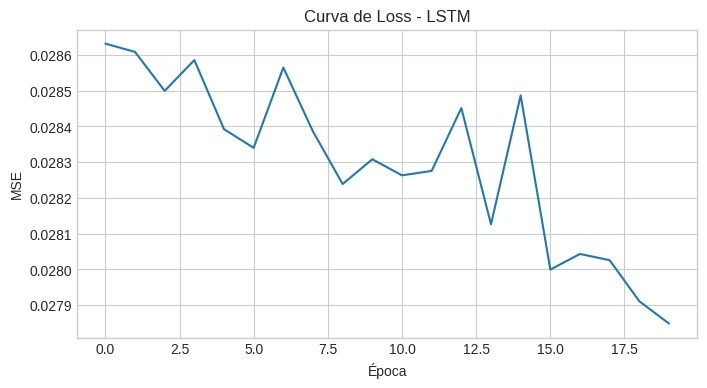

In [57]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.title("Curva de Loss - LSTM")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.show()

Métrica: MSE (Mean Squared Error), que mede o erro médio quadrático.  
Eixo X: Épocas de treinamento (0 a 20).  
Eixo Y: Valores de MSE, variando aproximadamente entre 0,0282 e 0,0288.  

O objeto retornado é o histórico de treinamento, contendo a função de perda por época, o que permite avaliar convergência e possível overfitting.

- Caso ideal: Loss começa alta e diminui suavemente → modelo aprendendo.

- Caso bom: Diminui e estabiliza → convergiu.

- Caso ruim: Loss sobe → instabilidade.

- Caso oscilando: Taxa de aprendizado pode estar alta.

Sobre a curva de loss (MSE por época)
- O gráfico mostra que o erro vai diminuindo ao longo das épocas, ainda que em uma faixa bem estreita (de ~0.0288 para ~0.0282).  
- Isso indica que o modelo está aprendendo, mas a melhoria é relativamente pequena — possivelmente já estava próximo de sua capacidade ótima desde o início.
- A curva está estável, sem sinais de *overfitting* ou explosão de gradiente, o que é positivo.

Interpretação geral
- O modelo aprende de forma consistente (curva de loss decrescente).  
- O desempenho em validação *walk-forward* é praticamente igual ao baseline, mostrando que o modelo não depende de condições artificiais e se mantém robusto.  
- Pequenas diferenças de RMSE são esperadas, já que o *walk-forward* é mais rigoroso e evita vazamento de informação.


In [58]:
# Tabela Final Comparativa
resultados_finais = pd.DataFrame({
    "Modelo": ["Baseline (Naive)", "SARIMA Estático", "SARIMA Rolling"],
    "RMSE": [rmse_naive, rmse, rmse_walk]
})

resultados_finais

,Modelo,RMSE
0,Baseline (Naive),8.080487
1,SARIMA Estático,6.264707
2,SARIMA Rolling,10.152035


 Comparação dos modelos
- Baseline (Naive): 8.08  
  Serve como referência simples: prever o próximo valor igual ao último observado.
- SARIMA Estático: 6.26  
  Melhor desempenho, com erro bem menor que o baseline. Isso mostra que o modelo consegue capturar padrões da série temporal quando treinado de forma fixa.
- SARIMA Rolling (Walk-forward): 10.15  
  Pior desempenho, com erro maior que o baseline. Isso indica que, ao atualizar o modelo passo a passo e testar em condições mais realistas, ele perde precisão.


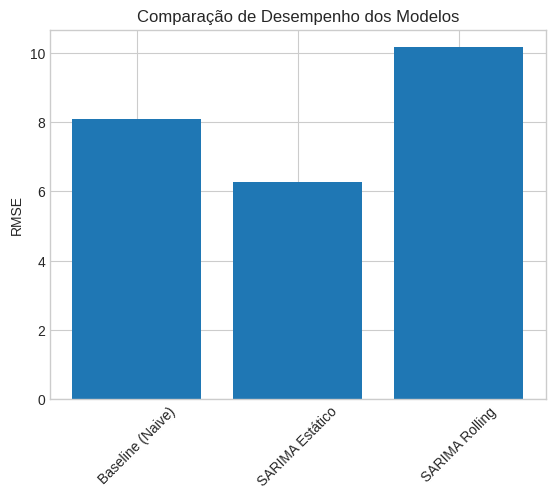

In [59]:
plt.figure()
plt.bar(resultados_finais["Modelo"], resultados_finais["RMSE"])
plt.title("Comparação de Desempenho dos Modelos")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()


Interpretação da Comparação de Desempenho dos Modelos
- O SARIMA Estático parece promissor, mas sua boa performance pode estar inflada por "vazamento de informação" ou por não refletir o cenário real de previsão contínua.
- O SARIMA Rolling expõe a fragilidade do modelo: quando colocado em prática, o erro aumenta bastante. Isso sugere que o modelo não está conseguindo se adaptar bem ao processo de previsão sequencial.
- O fato de o baseline ter erro menor que o rolling mostra que, em condições reais, o modelo não está superando nem a estratégia mais simples.



Conclusão

O desafio central consiste em verificar se há tendência estatisticamente significativa nas séries históricas de precipitação, vazão e nível nos municípios do Pantanal (MT e MS). A análise comparativa entre modelos evidenciou que, embora o SARIMA Estático apresente bom desempenho em cenários controlados, o SARIMA Rolling (walk-forward) revela uma deterioração acentuada em relação ao baseline. Esse contraste indica que as séries possuem alta complexidade temporal e possíveis mudanças estruturais, o que reforça a necessidade de investigar tendências de longo prazo em vez de assumir estacionaridade.

Os resultados mostram que o modelo não generaliza adequadamente em condições de previsão contínua, sugerindo que ajustes metodológicos ou a adoção de modelos alternativos são necessários para capturar melhor a dinâmica hidrológica. Assim, o SARIMA Estático pode ser utilizado como benchmark inicial, mas o Rolling evidencia limitações práticas que devem ser consideradas na análise.  